# XGBoost(eXtra Gradient Boost)
* 많은 데이터과학자가 XGBoost를 사용하며, 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 보임.
* XGBoost는 GBM에 기반을 두고있지만, GBM의 단점이 느린 수행속도와 과적합규제 부재등의 문제를 해결함.
* XGBoost는 병렬 cpu환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습완료가 가능.

## 파이썬 레퍼 XGBoost적용 - 위스콘신 유방암 예측

In [48]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# 평가치 출력을 위한 패키지 
import evaluation


%matplotlib inline

import warnings 
warnings.filterwarnings('ignore', category=RuntimeWarning)  # RuntimWarnig을 무시해라.

from matplotlib import font_manager, rc
font_name  = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family = font_name)

# 마이너스 부호 표시 
plt.rcParams['axes.unicode_minus'] = False

### 해당 데이터를 로드하고 데이터 윤곽 파악
* Feature : load_breas_cancer().data
* Label   : load_breast_cancer().target
* label name : load_breast_cancer().target_names
* Feature name : load_breast_cancer().feature_names
* 데이터세트에 대한 설명 : load_breast_cancer().DESCR

### 주요 변수에 대한 설명
위스콘신대에서 제공하는 유방암 환자의 진단 데이터 
* mean radius : 평균반경(중심에서 외벽까지의 거리의 평균값)
* mean texture  : 질감의 평균값(Grey-scale값)
* mean perimeter : 평균둘레
* mean area      : 면적의 평균          
* mean smoothness  : 매끄러움정도의 평균        
* mean compactness : 조그만 정도(둘레^2/면적 - 1)
* mean concavity   : 윤곽의 오목함정도의 평균
* mean concave points  : 오목한 평균점의 수
* mean symmetry       : 평균 대칭값  
* mean fractal dimension  : 프랙탈차원(해안선 근사 - 1)
* target : 0 - malignant(악성) , 1 - benign(양성)

In [18]:
datasets = load_breast_cancer()
X_features = datasets.data
y_label = datasets.target

cancer_df = pd.DataFrame(data = X_features, columns = datasets.feature_names)
cancer_df['target'] = datasets.target
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**레이블값의 분포 확인**
* 1(악성) - 357개, 2(양성) - 212개

In [23]:
print(datasets.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


**데이테세트 분리**
* 학습용 80% ,  테스트용 20%

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)
print(X_train.shape, y_test.shape)

(455, 30) (114,)


**XGBoost이용해 예측수행시 변환 데이터**
* XGBoost의 DMatrix를 이용해 넘파이 데이터를 변환

In [29]:
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

**XGBoost하이퍼 파라미터 설정**

In [35]:
params = {
    'max_depth': 3, # 트리의 최대깊이
    'eta': 0.1,     # learning_rate
    'objective': 'binary:logistic', # 예제데이터가 0또는 1 이진 분류이므로 목적함수(objective)는 이진 로지스틱(binary:logistic)
    'eval_metric':'logloss',  # 오류함수의 성능지표
    'early_stoppings': 100    # 조기 종료조건, 더 이상 지표개선이 없을때 
}
num_rounds = 400 # 부스팅 반복횟수

### 학습 수행

In [61]:
# train데이터세트는 'train', evaluation(test) 테이터세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stoppng파라미터를 train()함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain  =dtrain, num_boost_round = num_rounds, early_stopping_rounds = 100, evals = wlist)

[23:45:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0

[162]	train-logloss:0.00724	eval-logloss:0.08776
[163]	train-logloss:0.00722	eval-logloss:0.08778
[164]	train-logloss:0.00720	eval-logloss:0.08778
[165]	train-logloss:0.00718	eval-logloss:0.08752
[166]	train-logloss:0.00716	eval-logloss:0.08754
[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:

In [33]:
help(xgb.train)

Help on function train in module xgboost.training:

train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None)
    Train a booster with given parameters.
    
    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round: int
        Number of boosting iterations.
    evals: list of pairs (DMatrix, string)
        List of validation sets for which metrics will evaluated during training.
        Validation metrics will help us track the performance of the model.
    obj : function
        Customized objective function.
    feval : function
        Customized evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Validation metric needs to improve at least once in
        every **early_stopping_round

In [45]:
pred_probs = xgb_model.predict(dtest)

print("predict() 수행 결과값을 10개만 표시 , 예측 확률값으로 표시됨")
print(np.round(pred_probs[:10], 3))
# 예측 확률이 0.5보다 크면 1(악성), 0.5보다 작으면 양성으로 예측해 리스트 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print(preds[:10])

predict() 수행 결과값을 10개만 표시 , 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [38]:
help(xgb_model.predict)

Help on method predict in module xgboost.core:

predict(data, output_margin=False, ntree_limit=0, pred_leaf=False, pred_contribs=False, approx_contribs=False, pred_interactions=False, validate_features=True, training=False) method of xgboost.core.Booster instance
    Predict with data.
    
    .. note:: This function is not thread safe except for ``gbtree``
              booster.
    
      For ``gbtree`` booster, the thread safety is guaranteed by locks.
      For lock free prediction use ``inplace_predict`` instead.  Also, the
      safety does not hold when used in conjunction with other methods.
    
      When using booster other than ``gbtree``, predict can only be called
      from one thread.  If you want to run prediction using multiple
      thread, call ``bst.copy()`` to make copies of model object and then
      call ``predict()``.
    
    Parameters
    ----------
    data : DMatrix
        The dmatrix storing the input.
    
    output_margin : bool
        Whether to o

**예측치 평가**

In [50]:
evaluation.get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9744,                 F1 스코어 : 0.9806, FOC AUC값 : 0.9951


**plot_importance()를 이용한 시각화**

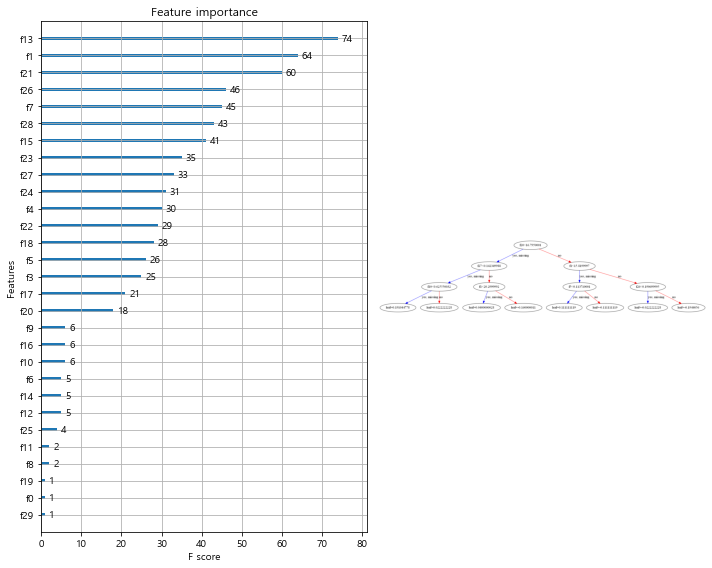

In [74]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 8))
xgb.plot_importance(xgb_model, ax = ax[0])
xgb.plot_tree(xgb_model, ax = ax[1])
xgb.to_graphviz(xgb_model)
plt.tight_layout()
plt.show()

### XGBClassifier을 이용한 학습 / 예측 수행

In [81]:
# 사이킷런의 래퍼 XGBoost클래스인 XGBClassifier 임포트 
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators  = 400, learning_rate = 0.1, max_depth= 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)

w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

# 예측 성능 평가 출력
evaluation.get_clf_eval(y_test, w_preds, w_pred_proba)

[00:14:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9744,                 F1 스코어 : 0.9806, FOC AUC값 : 0.9951


### 조기 중단

In [84]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1 , max_depth = 3)
evals = [(X_test, y_test)]

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals,  verbose = True)

w100_preds = xgb_wrapper.predict(X_test)
w100_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

# 예측 성능 평가 출력
evaluation.get_clf_eval(y_test, w100_preds, w100_preds_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

**조기중단값을 과격하게 10으로 주었다면?**
* 성능이 10번 반복 수행해서 개선여지가 안보인다면 조기중단.
* 52번과 61번을 비교해보면 됨.

* 출력결과

오차 행렬

[[34  3]<br>
 [ 2 75]]<br>
정확도 : 0.9561, 정밀도 : 0.9615, 재현율 : 0.9615,                 F1 스코어 : 0.9677, FOC AUC값 : 0.9947

In [86]:
from xgboost import XGBClassifier

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'logloss', eval_set = evals,  verbose = True)

w10_preds = xgb_wrapper.predict(X_test)
w10_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

# 예측 성능 평가 출력
evaluation.get_clf_eval(y_test, w10_preds, w10_preds_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

### XGBoost시각화

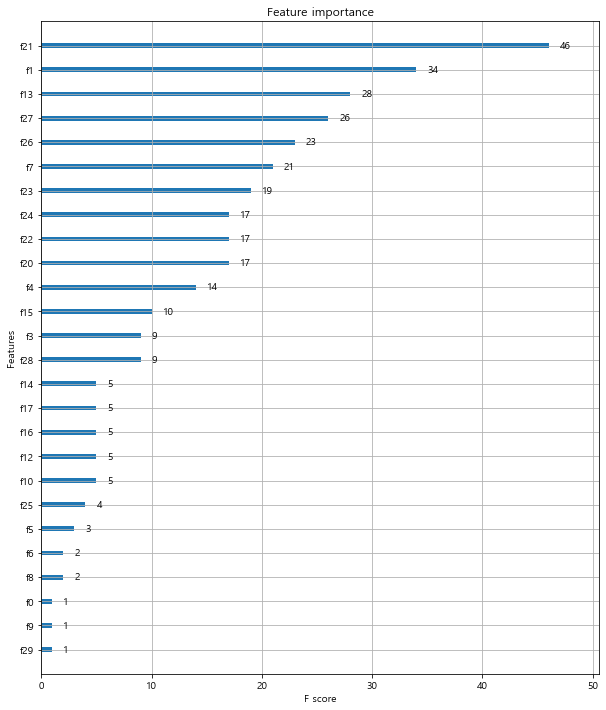

In [87]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
#사이킷 Wrapper를 보여줌.
plot_importance(xgb_wrapper, ax = ax)

**결과 정리**
* 211번 반복시 logloss가 0.08559이었는데 311번 반복 시 logloss가 0.08592인데, 211번에서 310번까지 100번 수행되는 동안 성능 평가지수가 향상되지 않았기 때문에 더 이상 반복하지 않고 멈춘것.


* 오차 행렬<br>
[[34  3]<br>
 [ 1 76]]<br>
정확도 : 0.9649, 정밀도 : 0.9620, 재현율 : 0.9620,                 F1 스코어 : 0.9744, FOC AUC값 : 0.9954

## 경사하강법

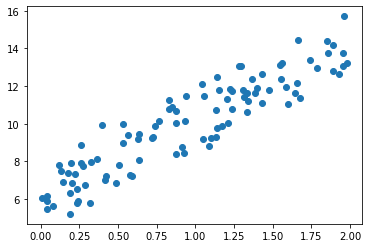

In [23]:
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

# y = 4X + 6을 근사(w1 = 4, s0 = 6),임의의 값은 노이즈를 위해 만듦.
x = np.random.rand(100,1) # 0과 1사이의 값을 100 * 1 형태로 리턴
X = 2 * x
# print(np.random.randn(100,1))
y = 6 + 4 * X + np.random.randn(100,1)

# Y, y 데이터 세트 산점도 시각화
plt.scatter(X, y)

In [24]:
def get_cost(y, pred):
    """
    실제값과 예측값을 인자로 받아 비용을 리턴
    """
    N = len(y)
    cost = np.sum(np.square( y = pred))/N
    return cost

3.678794411714423